In [6]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.patches as patches
import dateutil.parser

from matplotlib.dates import DateFormatter
from datetime import timedelta

books_chart = pd.read_csv("books_chart.csv")
books_chart["first_day_of_the_week"] = pd.to_datetime(books_chart["first_day_of_the_week"],
                                    infer_datetime_format=True)

In [7]:
plt.rcParams.update({'font.size': 15})

In [8]:
books_chart["year"] = books_chart["first_day_of_the_week"].dt.year
books_chart = books_chart[(books_chart["year"] >= 1958) & (books_chart["year"] <= 2023)]
books_chart.head()

,Unnamed: 0,author_title,first_day_of_the_week,position,last_week_position,weeks_on_chart,year
0,0,"ACT ONE, by Moss Hart. (Random House.)",1960-01-03,1,1.0,14,1960
1,1,"BARUCH: MY OWN STORY, by Bernard M. Baruch. (H...",1958-01-05,1,1.0,18,1958
2,2,"PROFILES IN COURAGE, by John F. Kennedy. (Harp...",1964-01-05,1,1.0,114,1964
3,3,"THE RISE AND FALL OF THE THIRD REICH, by Willi...",1961-01-01,1,1.0,9,1961
4,4,"THIS IS MY GOD, by Herman Wouk. (Doubleday and...",1960-01-03,2,2.0,13,1960


## Average lifetime

In [9]:
books_chart["max_weeks_on_chart"] = books_chart.groupby("author_title")["weeks_on_chart"].transform("max")

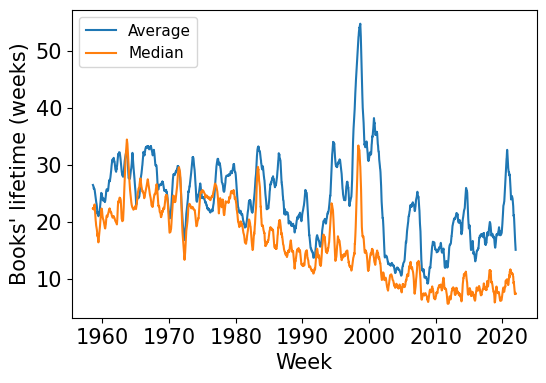

In [24]:
avg_weeks_on_chart = books_chart[["first_day_of_the_week", "max_weeks_on_chart"]].groupby(
    by="first_day_of_the_week").mean().rolling(window=30).mean()

median_weeks_on_chart = books_chart[["first_day_of_the_week", "max_weeks_on_chart"]].groupby(
    by="first_day_of_the_week").median().rolling(window=30).mean()

plt.figure(figsize=(6, 4))
plt.plot(avg_weeks_on_chart, label="Average")
plt.plot(median_weeks_on_chart, label="Median")
# avg_weeks_on_chart_plot = avg_weeks_on_chart.plot(kind='line', figsize=(5, 4), legend=False, rot=0)
# median_weeks_on_chart.plot(kind='line', figsize=(5, 4), legend=False, rot=0,
#     ax=avg_weeks_on_chart_plot, color="orange")

plt.xlabel("Week")
plt.ylabel("Books' lifetime (weeks)")
plt.legend(["Average", "Median"], fontsize=11, loc="upper left")

plt.savefig("figures/average_weeks_on_chart.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [11]:
def get_decade(year):
    return year - year % 10

books_chart["decade"] = books_chart["year"].apply(get_decade)

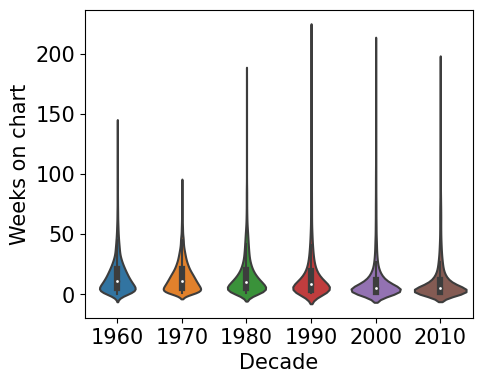

In [12]:
plt.figure(figsize=(5, 4))

sns.violinplot(x='decade', y="weeks_on_chart", order=range(1960, 2020, 10), data=books_chart)

plt.xlabel("Decade")
plt.ylabel("Weeks on chart")

plt.savefig("figures/lifeftime_distribution_per_decade.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Proportion of new podcasts

In [13]:
books_chart["new_book"] = books_chart["last_week_position"].map(
    lambda position: True if np.isnan(position) else False)

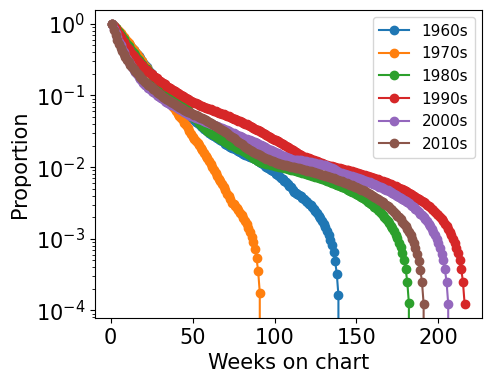

In [14]:
plt.figure(figsize=(5, 4))

for year in range(1960, 2020, 10):
    books_from_decade = books_chart[(books_chart["year"] >= year) &\
                                    (books_chart["year"] < year + 10)]
    proportion_of_books_older_than_x_weeks = []
    for i in range(1, 217):
        proportion_of_books_older_than_x_weeks.append(
            books_from_decade[books_from_decade["weeks_on_chart"] >= i].shape[0] / books_from_decade.shape[0])
    plt.plot(range(1, 217), proportion_of_books_older_than_x_weeks, marker='o')

plt.xlabel("Weeks on chart")
plt.ylabel("Proportion")
plt.legend([f"{year}s" for year in range(1960, 2020, 10)], fontsize=11, loc="upper right")
plt.yscale("log")
plt.savefig("figures/proportion_of_books_older_than_x_weeks_different_yearly_change.pdf", format="pdf")
plt.show()

## Position change

In [15]:
grouped = books_chart.groupby(["author_title"])
rows_to_add = []

for name, group in grouped:
    max_week = group["first_day_of_the_week"].max()

    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            rows_to_add.append({
                "author_title": row["author_title"],
                "first_day_of_the_week": row["first_day_of_the_week"] + timedelta(weeks=1),
                "position": 16,
                "last_week_position": row["position"],
                "weeks_on_chart": row["weeks_on_chart"]
            })

books_chart_with_disappeared_songs = pd.concat([books_chart, pd.DataFrame.from_records(rows_to_add)], ignore_index=True)

C:\Users\cutie\AppData\Local\Temp\ipykernel_23480\570518643.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:


In [16]:
def calculate_position_difference(position, last_week_position):
    if np.isnan(last_week_position):
        return 15 - position
    return last_week_position - position

books_chart_with_disappeared_songs["position_change"] = books_chart_with_disappeared_songs.apply(
    lambda x: calculate_position_difference(x["position"], x["last_week_position"]), axis=1)

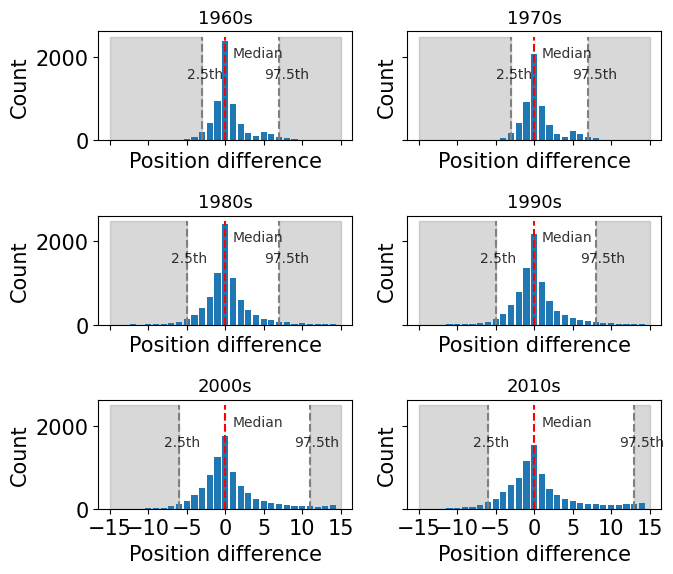

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(7, 6), sharex=True, sharey=True)

row = 0
col = 0

books_subset = books_chart_with_disappeared_songs[["year", "first_day_of_the_week", "position_change"]]

for year in range(1960, 2020, 10):
    decade_subset = books_subset[(books_subset["year"] >= year) &\
        (books_subset["year"] < year + 10)]["position_change"]
    count_changes = decade_subset.value_counts().sort_index()

    perecentile_25 = decade_subset.quantile(0.025)
    perecentile_975 = decade_subset.quantile(0.975)
    perecentile_50 = decade_subset.quantile(0.5)

    axes[row, col].vlines(perecentile_25, ymin=0, ymax=2500, color="grey", linestyle='--')
    axes[row, col].vlines(perecentile_975, ymin=0, ymax=2500, color="grey", linestyle='--')
    axes[row, col].vlines(perecentile_50, ymin=0, ymax=2500, color="red", linestyle='--')
    
    # mark the percentiles 
    rect_left = patches.Rectangle((-15, 0), 15 + perecentile_25, 2500, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_left)
    axes[row, col].text(perecentile_25 - 2, 1500, "2.5th", size = 10, alpha = 0.8)
    rect_right = patches.Rectangle((perecentile_975, 0), 15 - perecentile_975, 2500, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_right)
    axes[row, col].text(perecentile_975 - 2, 1500, "97.5th", size = 10, alpha = 0.8)

    axes[row, col].text(perecentile_50 + 1, 2000, "Median", size = 10, alpha = 0.8)

    axes[row, col].bar(count_changes.index, count_changes.values)
    axes[row, col].set_title(f"{year}s", fontsize=13)
    axes[row, col].set_xlabel("Position difference")
    axes[row, col].set_ylabel("Count")
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(8))
    col += 1
    if col == 2:
        col = 0
        row += 1

plt.locator_params(axis='x', nbins=8)
fig.tight_layout()
plt.savefig("figures/position_difference_distribution.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Normalized trajectories

In [18]:
books_chart["top_position"] = books_chart.groupby(
    ["author_title"])["position"].transform("min")

In [19]:
rows_to_add = []

for year in range(1960, 2020, 10):
    # songs from other decades
    books_from_other_decades = books_chart[(books_chart["year"] < year) |\
        (books_chart["year"] >= year + 10)][["author_title"]]
    
    books_in_decade = books_chart[(books_chart["year"] >= year) &\
        (books_chart["year"] < year + 10) & ~(books_chart["author_title"].isin(books_from_other_decades["author_title"]))][
        ["author_title", "weeks_on_chart", "position", "first_day_of_the_week", "year", "top_position"]]
    grouped = books_in_decade.groupby(["author_title"])

    min_first_week = books_in_decade["first_day_of_the_week"].min().to_pydatetime()

    for name, group in grouped:
        max_week = group["first_day_of_the_week"].max().to_pydatetime()

        for row_index, row in group.iterrows():
            if row["first_day_of_the_week"] == max_week:
                week_date = row["first_day_of_the_week"] + timedelta(weeks=1)

                while week_date < dateutil.parser.parse(f"{year + 9}-12-31"):
                    rows_to_add.append({
                        "author_title": row["author_title"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 16,
                        "first_day_of_the_week": week_date,
                        "year": week_date.year,
                        "top_position": row["top_position"]
                    })
                    week_date += timedelta(weeks=1)
books_chart_with_empty_weeks = pd.concat([books_chart[["author_title",
    "weeks_on_chart", "position", "first_day_of_the_week", "year", "top_position"]], pd.DataFrame(rows_to_add)], ignore_index=True)

C:\Users\cutie\AppData\Local\Temp\ipykernel_23480\949049813.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:
C:\Users\cutie\AppData\Local\Temp\ipykernel_23480\949049813.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:
C:\Users\cutie\AppData\Local\Temp\ipykernel_23480\949049813.py:15: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:
C:\Users\cutie\AppData\Local\Temp\ipykernel_23480\94

In [20]:
books_chart_with_empty_weeks["first_week"] = books_chart_with_empty_weeks.groupby(["author_title"])["first_day_of_the_week"].transform("min")

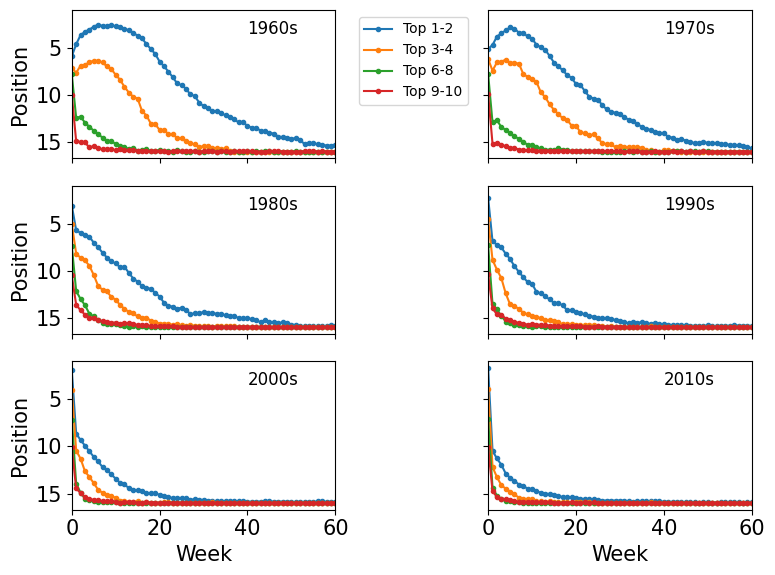

In [23]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # all books in the decade
    all_books_in_decade = books_chart_with_empty_weeks[(books_chart_with_empty_weeks["year"] >= year) &\
        (books_chart_with_empty_weeks["year"] < year + 10)][["author_title", "first_day_of_the_week", "top_position", "position",
            "first_week"]]

    # books from other decades
    books_from_other_decades = books_chart[(books_chart["year"] < year) |\
        (books_chart["year"] >= year + 10)]["author_title"]

    for top_position, low_positions in [(1, 2),  (3, 4), (6, 8), (9, 10)]:
        # books that reached top 50 in the decade
        top_x_positions_in_decade = all_books_in_decade[(all_books_in_decade["top_position"] <= low_positions) &\
            (all_books_in_decade["top_position"] >= top_position)]["author_title"]

        # take books only from this decade
        top_x_positions_in_decade = top_x_positions_in_decade[~top_x_positions_in_decade.isin(books_from_other_decades)]

        # take all positions of the books
        top_x_positions_in_decade = books_chart_with_empty_weeks[books_chart_with_empty_weeks["author_title"].isin(top_x_positions_in_decade)][["author_title",
                "position", "first_day_of_the_week", "first_week"]]

        min_first_week = top_x_positions_in_decade["first_day_of_the_week"].min().to_pydatetime()

        top_x_positions_in_decade["first_day_of_the_week"] = top_x_positions_in_decade.apply(lambda row:
            int(((min_first_week + timedelta(
                    days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

        top_x_positions_in_decade.set_index("first_day_of_the_week", inplace=True)
        top_x_positions_in_decade.sort_index(inplace=True)

        axes[row_i, col_i].plot(top_x_positions_in_decade.groupby("first_day_of_the_week")["position"].mean(),
            marker='o', label=f"Top {top_position}-{low_positions}", ms=3)

    axes[row_i, col_i].text(40, 3.5, f"{year}s", fontsize=12)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Week")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")
    if row_i == 0 and col_i == 1:
        axes[row_i, col_i].legend(fontsize=10, bbox_to_anchor=(-0.05, 1))
    axes[row_i, col_i].set_xlim([0, 60])

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/average_position_change_per_top_position_decades.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Average max/past/future weeks on chart

In [77]:
def get_past_weeks(row):
    top_position = row["top_position"].iloc[0]
    # take first day of the week when the podcast was in top position
    top_position_time = row[
        (row["position"] == top_position)]["first_day_of_the_week"].values[0]
    past_weeks = row[
        (row["first_day_of_the_week"] <= top_position_time)]["weeks_on_chart"].max()
    return past_weeks

In [78]:
def get_future_weeks(row):
    top_position = row["top_position"].iloc[0]
    past_weeks = row["past_weeks"].iloc[0]
    # take first day of the week when the podcast was in top position
    top_position_time = row[
        (row["position"] == top_position)]["first_day_of_the_week"].values[0]
    max_weeks = row[
        (row["first_day_of_the_week"] > top_position_time)]["weeks_on_chart"].max()
    if max_weeks is np.nan or max_weeks == 0:
        return 0
    future_weeks = max_weeks - past_weeks
    if future_weeks is np.nan or future_weeks < 0:
        return 0
    return future_weeks

In [79]:
df_past_weeks = books_chart.groupby(["author_title"]).apply(
    lambda row: get_past_weeks(row)).rename("past_weeks").reset_index()
books_chart = books_chart.merge(df_past_weeks[["author_title", "past_weeks"]], on=["author_title"], how="left")

df_future_weeks = books_chart.groupby(["author_title"]).apply(
    lambda row: get_future_weeks(row)).rename("future_weeks").reset_index()
books_chart = books_chart.merge(df_future_weeks[["author_title", "future_weeks"]], on=["author_title"], how="left")

books_chart["max_weeks_on_chart"] = books_chart.groupby(["author_title"])["weeks_on_chart"].transform("max")

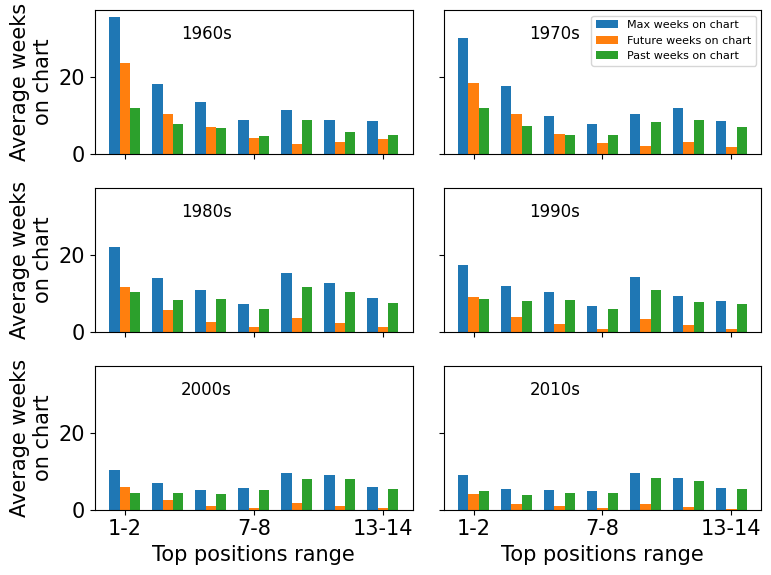

In [83]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # songs from other decades
    books_from_other_decades = books_chart[(books_chart["year"] < year) |\
        (books_chart["year"] >= year + 10)][["author_title"]]

    # take songs only from this decade
    books_in_decade = books_chart[~(books_chart["author_title"].isin(books_from_other_decades["author_title"]))]
    
    top_positions_max = pd.DataFrame(columns=["top_positions_range", "avg_weeks"])
    top_positions_future = pd.DataFrame(columns=["top_positions_range", "avg_weeks"])
    top_positions_past = pd.DataFrame(columns=["top_positions_range", "avg_weeks"])
    for top_position in range(2, 16, 2):
        avg_max_weeks = books_in_decade[(books_in_decade["top_position"] <= top_position) &\
            (books_in_decade["top_position"] > top_position - 2)].groupby(
                ["author_title"])["max_weeks_on_chart"].first().mean()
        new_row_max = pd.DataFrame({"top_positions_range": f"{top_position - 1}-{top_position}",
            "avg_weeks": avg_max_weeks}, index=[0])
        top_positions_max = pd.concat([top_positions_max, new_row_max])

        avg_future_weeks = books_in_decade[(books_in_decade["top_position"] <= top_position) &\
            (books_in_decade["top_position"] > top_position - 2)].groupby(
                ["author_title"])["future_weeks"].first().mean()
        new_row_future = pd.DataFrame({"top_positions_range": f"{top_position - 1}-{top_position}",
            "avg_weeks": avg_future_weeks}, index=[0])
        top_positions_future = pd.concat([top_positions_future, new_row_future])

        avg_past_weeks = books_in_decade[(books_in_decade["top_position"] <= top_position) &\
            (books_in_decade["top_position"] > top_position - 2)].groupby(
                ["author_title"])["past_weeks"].first().mean()
        new_row_past = pd.DataFrame({"top_positions_range": f"{top_position - 1}-{top_position}",
            "avg_weeks": avg_past_weeks}, index=[0])
        top_positions_past = pd.concat([top_positions_past, new_row_past])

    ind = np.arange(top_positions_max["top_positions_range"].shape[0])
    bar_width = 0.24
    axes[row_i, col_i].bar(ind, top_positions_max["avg_weeks"], bar_width, label="Max weeks on chart")
    axes[row_i, col_i].bar(ind + bar_width, top_positions_future["avg_weeks"], bar_width, label="Future weeks on chart")
    axes[row_i, col_i].bar(ind + 2*bar_width, top_positions_past["avg_weeks"], bar_width, label="Past weeks on chart")
    axes[row_i, col_i].text(0.27, 0.8, f"{year}s", fontsize=12, transform=axes[row_i, col_i].transAxes)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Top positions range")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Average weeks\non chart")
    axes[row_i, col_i].xaxis.set_major_locator(plt.MaxNLocator(5))
    axes[row_i, col_i].set_xticks(ind[::3] + bar_width, top_positions_max["top_positions_range"].tolist()[::3])
    if row_i == 0 and col_i == 1:
        axes[row_i, col_i].legend(fontsize=8)

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.savefig("figures/average_weeks_on_chart_per_top_position_decades.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Max weeks distribution

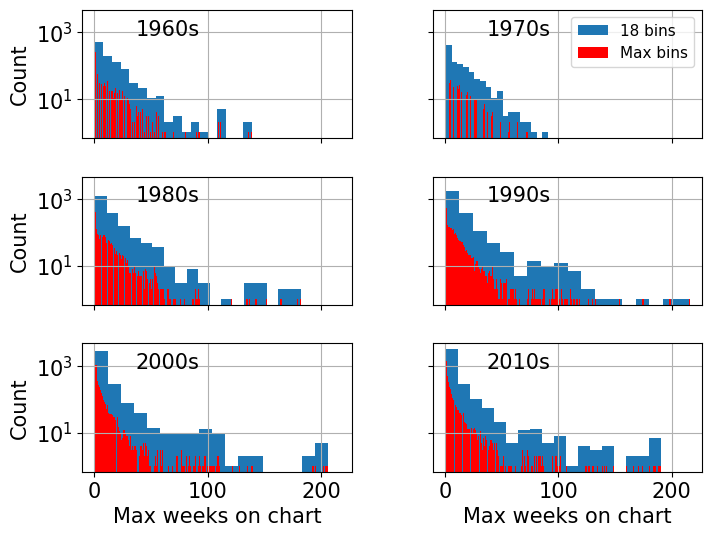

In [85]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True, sharex=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    books_in_decade = books_chart[(books_chart["year"] >= year) &\
        (books_chart["year"] < year + 10)][["author_title", "weeks_on_chart"]]

    max_weeks_on_chart = books_in_decade[["author_title", "weeks_on_chart"]].groupby(
        by=["author_title"]).max().reset_index()

    max_weeks_on_chart.hist(bins=18, figsize=(8, 6), legend=False, ax=axes[row_i, col_i])
    max_weeks_on_chart.hist(bins=books_chart["weeks_on_chart"].max(), figsize=(8, 6), legend=False, color="red", ax=axes[row_i, col_i])

    axes[row_i, col_i].text(0.2, 0.8, f"{year}s", transform=axes[row_i, col_i].transAxes)
    axes[row_i, col_i].set_title(None)
    # axes[row_i, col_i].set_xlabel("Max weeks on chart")
    # axes[row_i, col_i].set_ylabel("Count")
    # axes[row_i, col_i].legend(["18 bins", "Max bins"])
    axes[row_i, col_i].set_yscale("log")
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Max weeks on chart")
    else:
        axes[row_i, col_i].set_xlabel(None)
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Count")
    else:
        axes[row_i, col_i].set_ylabel(None)
    if row_i == 0 and col_i == 1:
        axes[row_i, col_i].legend(["18 bins", "Max bins"], fontsize=11, loc="upper right")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

plt.savefig("figures/max_weeks_on_chart_distribution_decades.pdf", format="pdf", bbox_inches="tight")
plt.show()
